# merging modis granules

This notebook takes geotiffs written with NASA's sinusoidal crs and resamples them onto a common
grid with a UTM zone 10 crs [epsg 3157 ](https://spatialreference.org/ref/epsg/3157)

We use [rioxarray](https://corteva.github.io/rioxarray/stable/) to get the crs information and [pyresample](https://pyresample.readthedocs.io/en/latest/concepts/index.html) to do the resampling.  The [pyproj](https://pyproj4.github.io/pyproj/stable/index.html) package is used to transform the lon/lat bounding box
into UTM coodinates for the area_def.

In [1]:
import rioxarray
import xarray
from pathlib import Path
import cartopy.crs as ccrs
import cartopy
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pyresample
from pyproj import Transformer, transform
from pyresample.geometry import AreaDefinition

## open the images using rioxarray

The default nasa projection is a [custom sinusoidal grid](https://pro.arcgis.com/en/pro-app/3.1/help/mapping/properties/sinusoidal.htm#:~:text=Sinusoidal%20is%20a%20pseudocylindric%20projection,central%20meridian%20and%20equally%20spaced.)

use rioxarray to get the coordinate reference system for the modis images

In [2]:
#images = (Path.home() / "repos/a448_2024/data").glob("*MYD*tif")
image_dir = Path.home() / ("Dropbox/phil_files/teaching/a448_2024/"
                         "propposals/hannah/MODIS_images/MODIS_Images")
year_dir = image_dir / "2021_MODIS_images"
images = list(year_dir.glob("*.tif"))
image1, image2 = images
rio_image1 = rioxarray.open_rasterio(image1, mask_and_scale = True)
rio_image2 = rioxarray.open_rasterio(image2, mask_and_scale = True)
wkt_text1 = rio_image1.spatial_ref.crs_wkt

Here is the sinusoidal crs in wkt format

In [3]:
rio_image1

<xarray.DataArray (band: 1, y: 1200, x: 1200)>
[1440000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.001e+07 -1.001e+07 ... -8.897e+06 -8.896e+06
  * y            (y) float64 5.559e+06 5.558e+06 ... 4.449e+06 4.448e+06
    spatial_ref  int64 0
Attributes: (12/122)
    add_offset_err:                     0
    ALGORITHMPACKAGEACCEPTANCEDATE:     102004
    ALGORITHMPACKAGEMATURITYCODE:       Normal
    ALGORITHMPACKAGENAME:               MOD_PR11A
    ALGORITHMPACKAGEVERSION:            6
    AREA_OR_POINT:                      Area
    ...                                 ...
    TileID:                             51009004
    units:                              K
    valid_range:                        7500, 65535
    VERSIONID:                          61
    VERTICALTILENUMBER:                 4
    WESTBOUNDINGCOORDINATE:             -140.021612487585

In [4]:
wkt_text1

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

## Create three area_defs for pyresample

We need area_defs for the two modis tif files, and we need to create a third area_def that we are going to resample those two images into.





### make geodetic and utm zone 10N pyproj crs objects

We need to transform the lon/lat bounding box from geodetic coords (WGS84)  into utm coordinates (32610)

Start by creating two pyproj crs objects

In [5]:
crs_geodetic = pyproj.CRS("WGS84")
crs_zone10N = pyproj.CRS(32610)
crs_zone10N

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
crs_geodetic

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Get the region to resample into

We need the lower left and upper right corners of the region of interest in UTM coordinates
lat/lon is geodetic (epsg:4326)  and utm zone 10N is epsg:32610

**note that epsg:4326 is lat,lon  and epsg:32610 is x, y -- i.e. flipped**

In [7]:
ll_lat, ll_lon = (49, -123.26)
ur_lat, ur_lon = (49.35, -122.50)
transformer = Transformer.from_crs(4326, 32610)
ll_x, ll_y = transformer.transform(ll_lat,ll_lon)
ur_x, ur_y = transformer.transform(ur_lat,ur_lon)
print(f"{(ll_x,ur_x,ll_y,ur_y)=}")
area_extent = (ll_x,ur_x,ll_y,ur_y)

(ll_x,ur_x,ll_y,ur_y)=(480982.95259714004, 536314.2562688388, 5427488.345747969, 5466485.02426247)


### get the pyresample area_defs from the images

Also get the crs (same for both images)

In [8]:
crs_nasa = pyproj.crs.CRS(wkt_text1)
rio1_def = pyresample.utils.rasterio.get_area_def_from_raster(str(images[0]),projection=crs_nasa)
rio2_def = pyresample.utils.rasterio.get_area_def_from_raster(str(images[1]),projection=crs_nasa)
rio1_def

Area ID: None
Description: None
Projection: {'R': '6371007.181', 'lon_0': '0', 'no_defs': 'None', 'proj': 'sinu', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 1200
Number of rows: 1200
Area extent: (-10007554.6779, 4447802.0791, -8895604.1581, 5559752.5988)

In [9]:
rio2_def

Area ID: None
Description: None
Projection: {'R': '6371007.181', 'lon_0': '0', 'no_defs': 'None', 'proj': 'sinu', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 1200
Number of rows: 1200
Area extent: (-8895604.1581, 4447802.0791, -7783653.6384, 5559752.5988)

### Construct the pyresample area_def for the bounding box

We need:

- area_id: ID of area
- description: Description
- proj_id: ID of projection (being deprecated)
- projection: Proj4 parameters as a dict or string
- width: Number of grid columns
- height: Number of grid rows
- area_extent: (lower_left_x, lower_left_y, upper_right_x, upper_right_y)


We want our area_extent to have these corners, need to project to utm zone 10 coords

### Get the extent in UTM Zone10N coords

### set the rest of the values

In [10]:
area_id = "vancouver"
projection = crs_zone10N.to_dict()
proj_id = "UTM Zone10"
description = "vancouver"
width = 60
height = 42
area_extent = ll_x, ll_y, ur_x, ur_y

/Users/phil/mini310/envs/a405/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


### Make the destination area_def

In [11]:
vancouver_area_def = AreaDefinition(area_id, description, proj_id, projection,
                          width, height, area_extent)

In [12]:
vancouver_area_def

Area ID: vancouver
Description: vancouver
Projection ID: UTM Zone10
Projection: {'datum': 'WGS84', 'no_defs': 'None', 'proj': 'utm', 'type': 'crs', 'units': 'm', 'zone': '10'}
Number of columns: 60
Number of rows: 42
Area extent: (480982.9526, 5427488.3457, 536314.2563, 5466485.0243)

## resample both images into the vancouver area_def

In [35]:
from matplotlib import cm
from matplotlib.colors import Normalize
import copy
cmap = plt.get_cmap("plasma")
vmin=300
vmax = 330
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
over = 'w'
under='k'
missing='0.4'
cmap=copy.copy(cmap)
cmap.set_over(over)
cmap.set_under(under)
cmap.set_bad(missing)

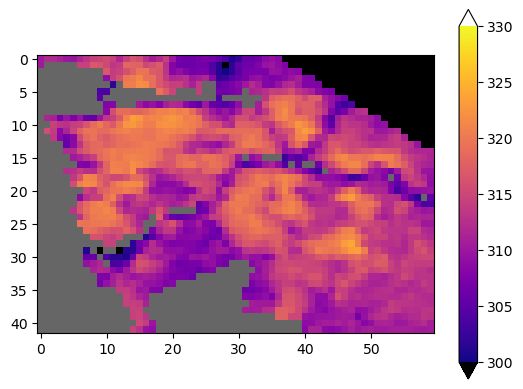

In [36]:
data1 = rio_image1.data.ravel()
data2 = rio_image2.data.ravel()
out1 = pyresample.kd_tree.resample_nearest(rio1_def,data1, vancouver_area_def,radius_of_influence=500,fill_value=0)
out2 = pyresample.kd_tree.resample_nearest(rio2_def,data2, vancouver_area_def,radius_of_influence=500,fill_value=0)
cs = plt.imshow(out1,cmap=cmap,norm=the_norm)
fig = plt.gcf()
fig.colorbar(cs, extend="both");

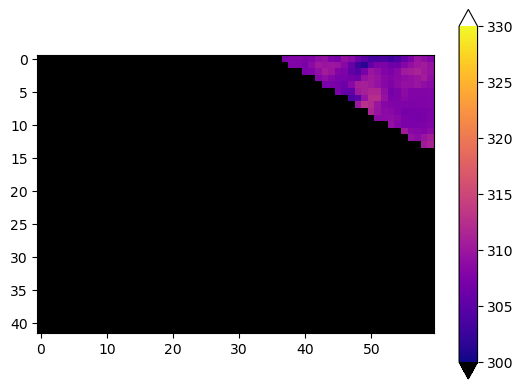

In [37]:
cs = plt.imshow(out2,cmap=cmap,norm=the_norm)
fig = plt.gcf()
fig.colorbar(cs, extend="both");

## Create the merged image

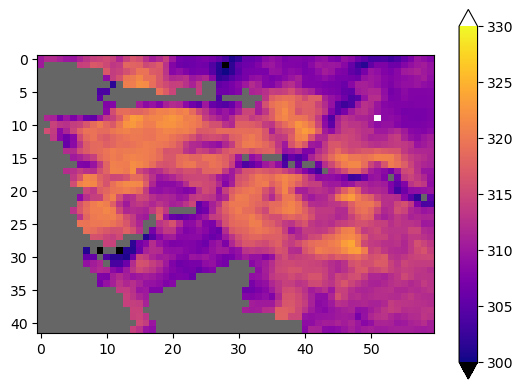

In [39]:
merge = out1 + out2
hit = merge ==0
merge[hit]=np.nan
cs = plt.imshow(merge,cmap=cmap,norm=the_norm)
fig = plt.gcf()
fig.colorbar(cs, extend="both");

In [44]:
hit = merge > 500
merge[hit]=np.nan

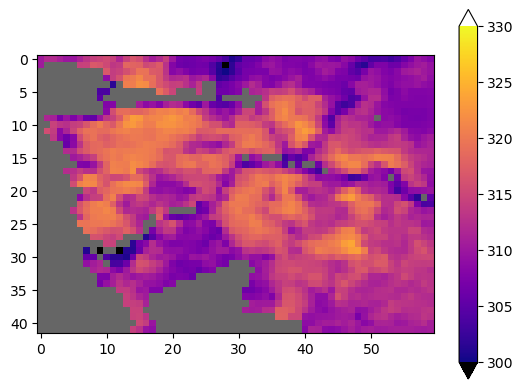

In [45]:
cs = plt.imshow(merge,cmap=cmap,norm=the_norm)
fig = plt.gcf()
fig.colorbar(cs, extend="both");